## 写在前面

具体对比一下PCA和EOF函数对于相同数据的实现效果，本质上是相同的方法。

这里只是进行验证。

使用的是sst月平均资料，分别调用以下前两个方法，

虽然下面给出了三种方法，但是我没记错的话，

geocat这个库在windows下面装不了

```python
from sklearn.decomposition import PCA
from eofs.standard import Eof
from geocat.comp import eofunc_eofs, eofunc_pcs
```

因为PCA默认使用 SVD（奇异值分解） 来进行主成分分析，而不是直接计算协方差矩阵，这在时间和内存效率上都更优，特别是在时间维度很长（样本多）的情况下。

具体使用的教程可以参考我之前的记录：

- https://blog.csdn.net/weixin_44237337/article/details/137378776?spm=1011.2415.3001.5331


## 数据获取

对于代码中使用的数据，如果文件比较小，可以上传，基本上都会上传到test_data文件夹下。

比如说下面使用的`lsmask.nc`

而sst数据使用的是`NOAA OI SST V2 High Resolution Dataset`的`nc`文件，下载路径为：

- https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2.highres/

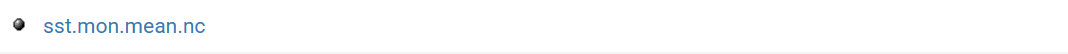

```python

File "oisst_monthly.nc"
File type: NetCDF-3/CDM
 
netcdf I:\oisst_monthly.nc {
  dimensions:
    lat = 180;
    lon = 360;
    time = UNLIMITED;   // (476 currently)
    nbnds = 2;
  variables:
    float lat(lat=180);
      :units = "degrees_north";
      :long_name = "Latitude";
      :actual_range = 89.5f, -89.5f; // float
      :standard_name = "latitude";
      :axis = "Y";
      :coordinate_defines = "center";

    float lon(lon=360);
      :units = "degrees_east";
      :long_name = "Longitude";
      :actual_range = 0.5f, 359.5f; // float
      :standard_name = "longitude";
      :axis = "X";
      :coordinate_defines = "center";

    short sst(time=476, lat=180, lon=360);
      :long_name = "Monthly Mean of Sea Surface Temperature";
      :unpacked_valid_range = -5.0f, 40.0f; // float
      :actual_range = -1.7999996f, 35.56862f; // float
      :units = "degC";
      :add_offset = 0.0f; // float
      :scale_factor = 0.01f; // float
      :missing_value = 32767S; // short
      :precision = 2S; // short
      :least_significant_digit = 2S; // short
      :var_desc = "Sea Surface Temperature";
      :dataset = "NOAA Optimum Interpolation (OI) SST V2";
      :level_desc = "Surface";
      :statistic = "Mean";
      :parent_stat = "Weekly Mean";
      :standard_name = "sea_surface_temperature";
      :cell_methods = "time: mean (monthly from weekly values interpolated to daily)";
      :valid_range = -500S, 4000S; // short

    double time(time=476);
      :units = "days since 1800-1-1 00:00:00";
      :long_name = "Time";
      :actual_range = 66443.0, 80900.0; // double
      :delta_t = "0000-01-00 00:00:00";
      :avg_period = "0000-01-00 00:00:00";
      :prev_avg_period = "0000-00-07 00:00:00";
      :standard_name = "time";
      :axis = "T";
      :bounds = "time_bnds";

    double time_bnds(time=476, nbnds=2);
      :long_name = "Time Boundaries";

  // global attributes:
  :title = "NOAA Optimum Interpolation (OI) SST V2";
  :Conventions = "CF-1.0";
  :history = "Wed Apr  6 13:47:45 2005: ncks -d time,0,278 SAVEs/sst.mnmean.nc sst.mnmean.nc\nCreated 10/2002 by RHS";
  :comments = "Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmith, D.C. Stokes, and W. Wang, 2002: An Improved In Situ and Satellite\nSST Analysis for Climate, J. Climate";
  :platform = "Model";
  :source = "NCEP Climate Modeling Branch";
  :institution = "National Centers for Environmental Prediction";
  :References = "https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html";
  :dataset_title = "NOAA Optimum Interpolation (OI) SST V2";
  :source_url = "http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/";
}
```

## 导入工具包

In [27]:

"""
优化后的EOF/PCA分析程序
用于气象数据的EOF分析，支持多种方法对比

@author: xpji (优化版)
"""

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.signal import windows
from sklearn.decomposition import PCA
from eofs.standard import Eof
import os
import cmaps
import matplotlib as mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12




加载数据: I:/oisst_monthly.nc
加载掩膜: I:/lsmask.nc
执行基于sklearn.PCA的EOF分析...
PCA分析完成，解释方差: [0.45537656 0.07827968 0.06229725]
执行基于eofs的EOF分析...
eofs分析完成，解释方差: [0.48220126 0.07897201 0.05866515]


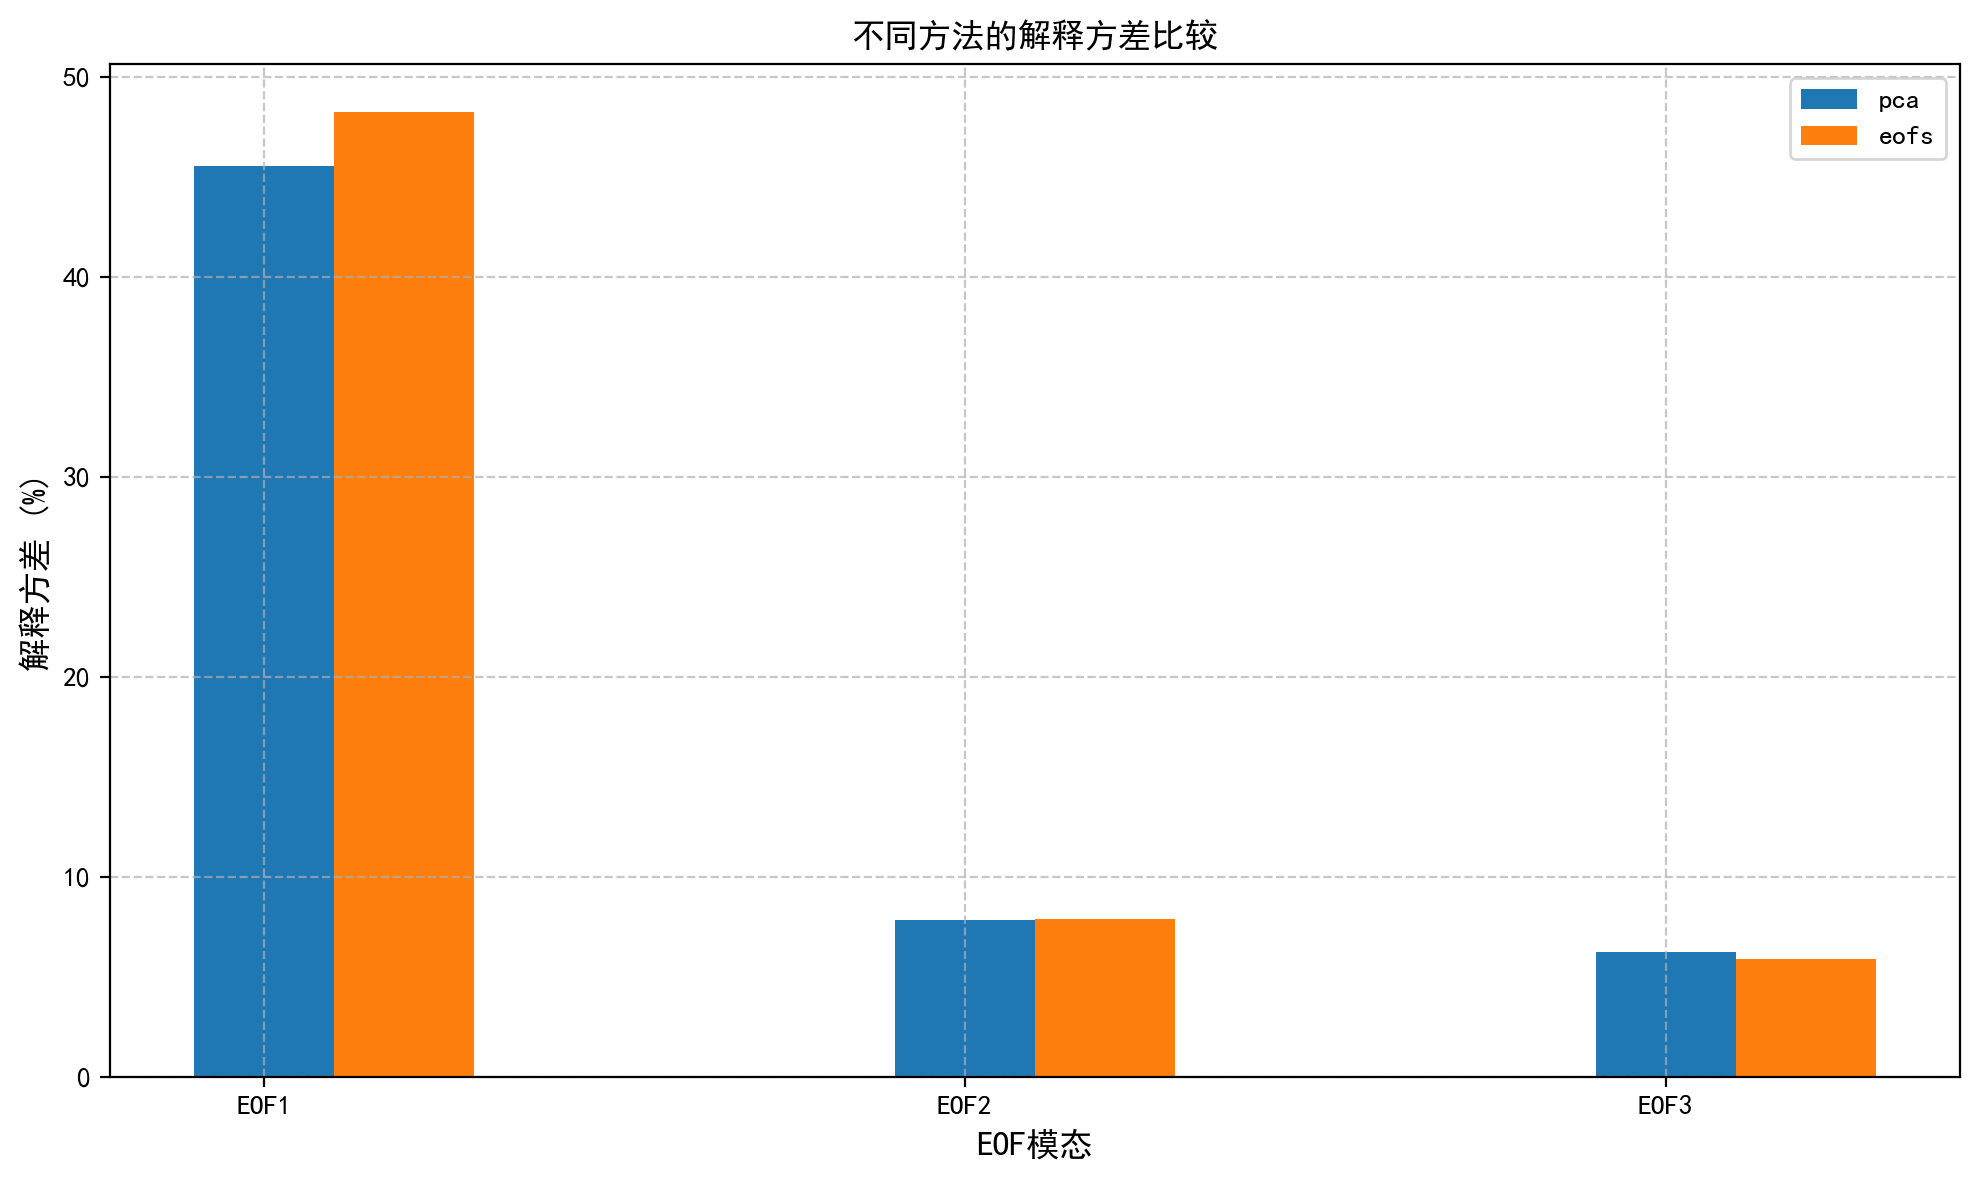

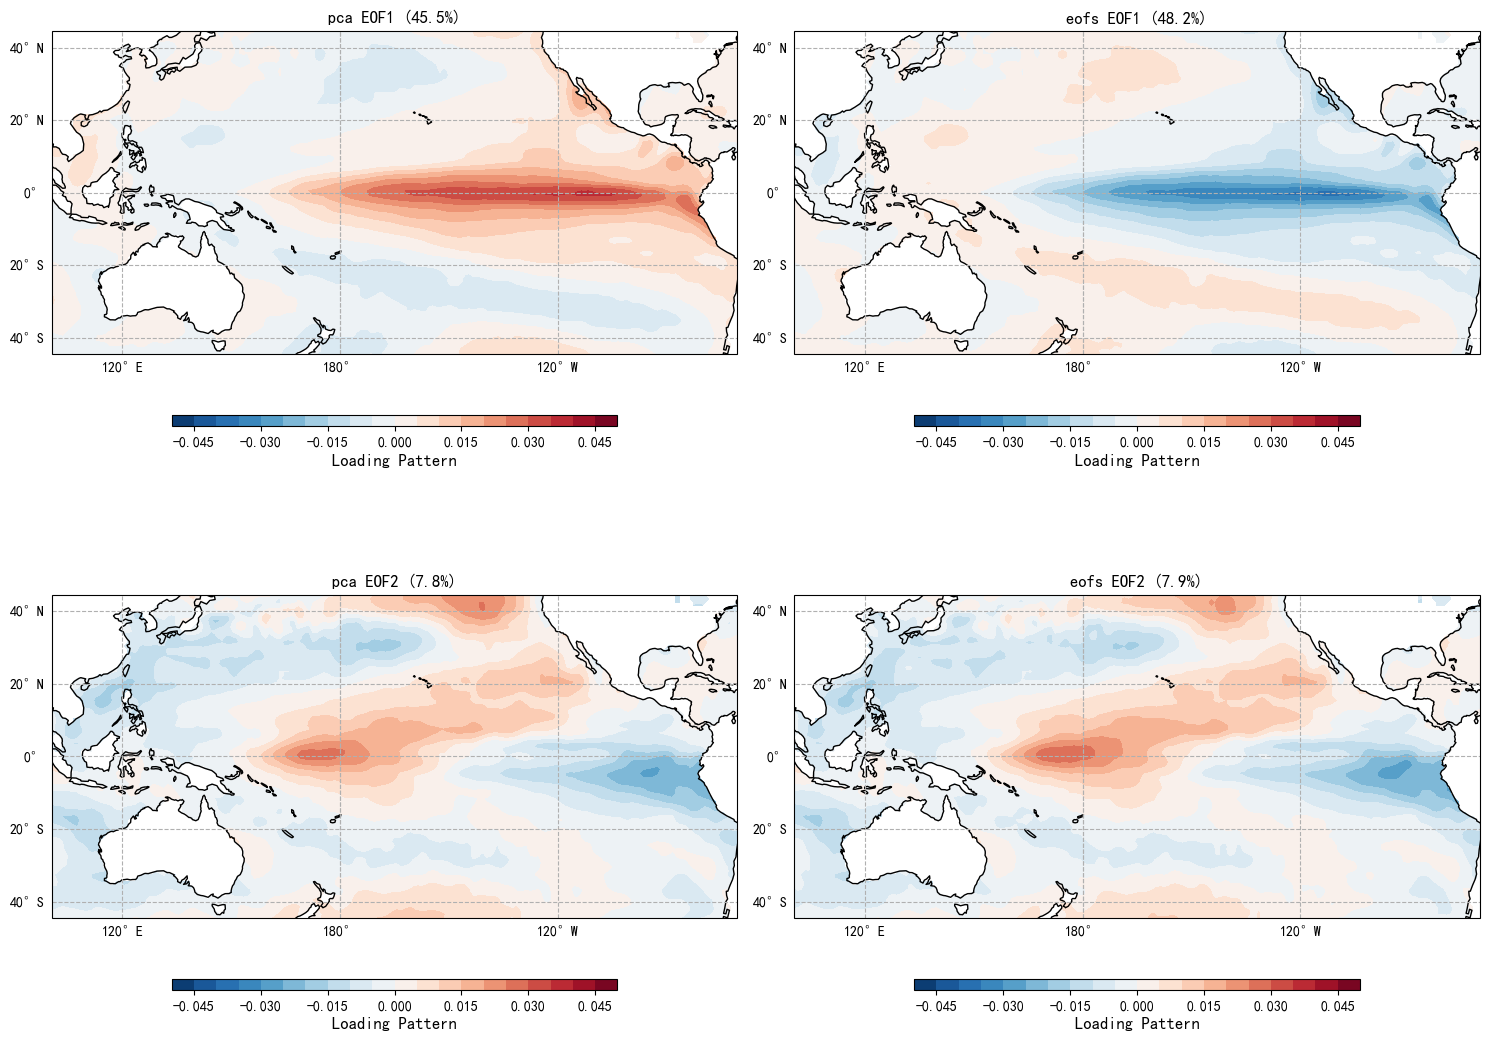

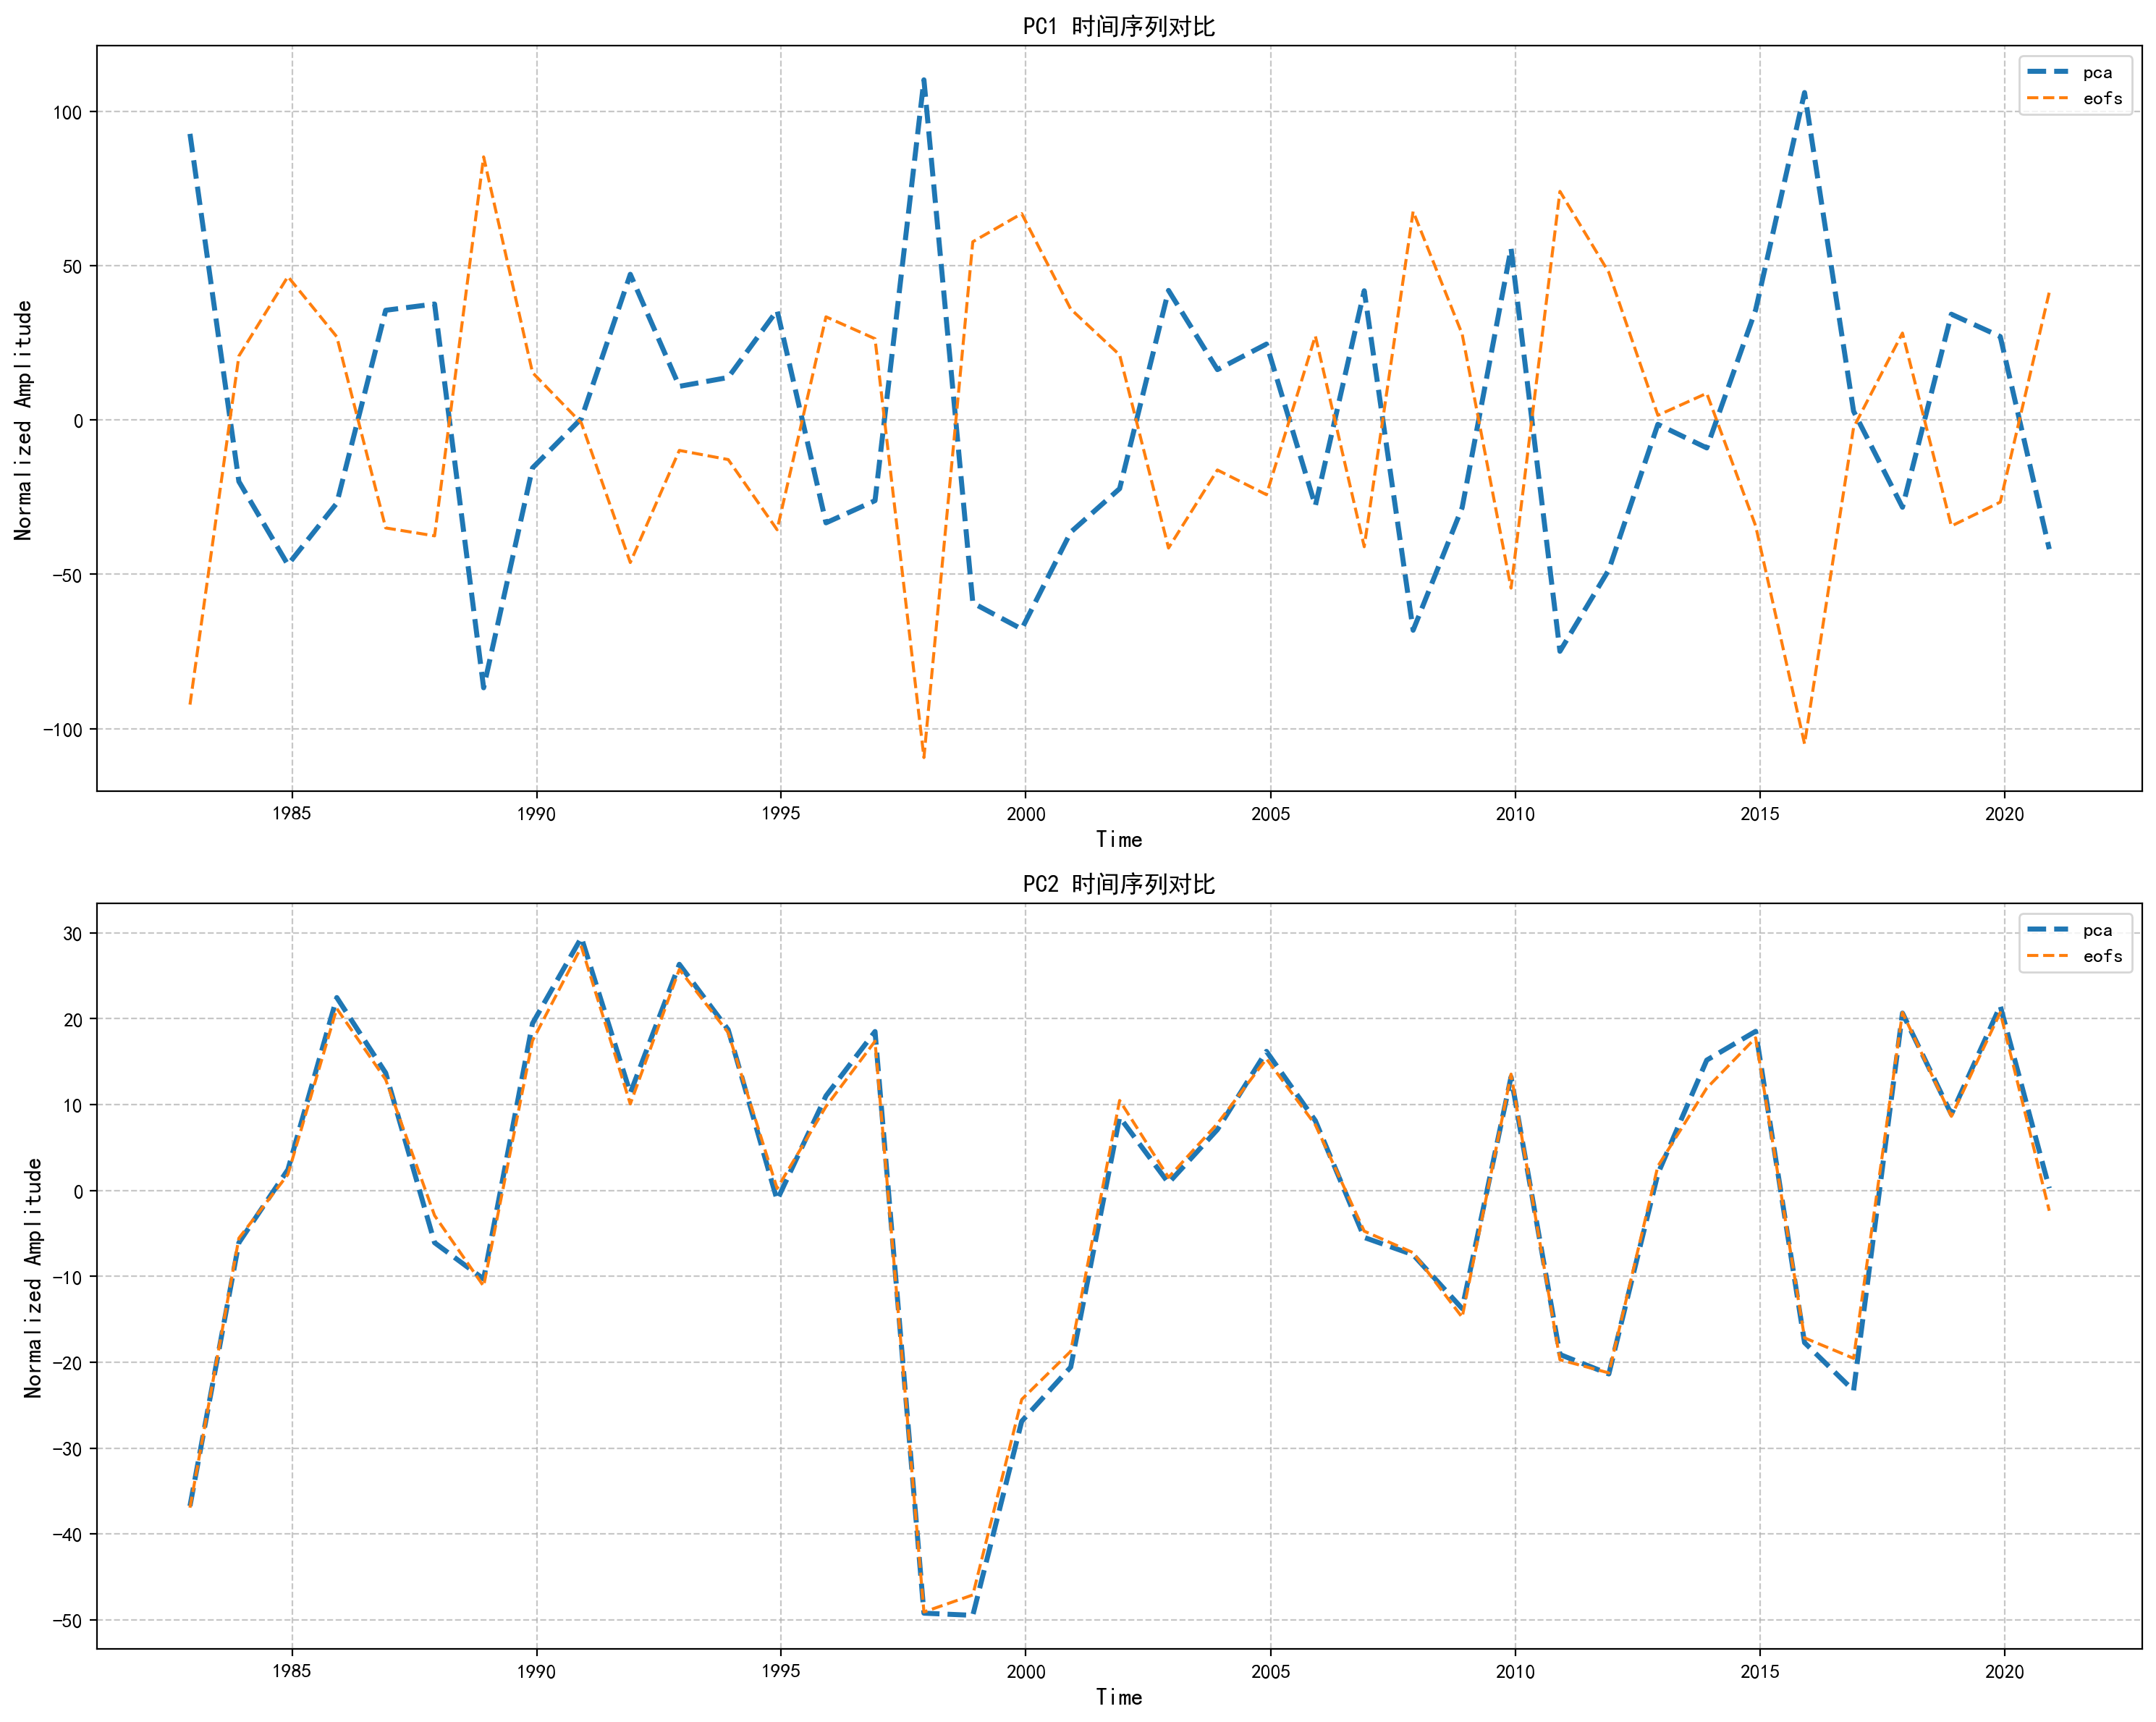

<Figure size 1200x600 with 0 Axes>

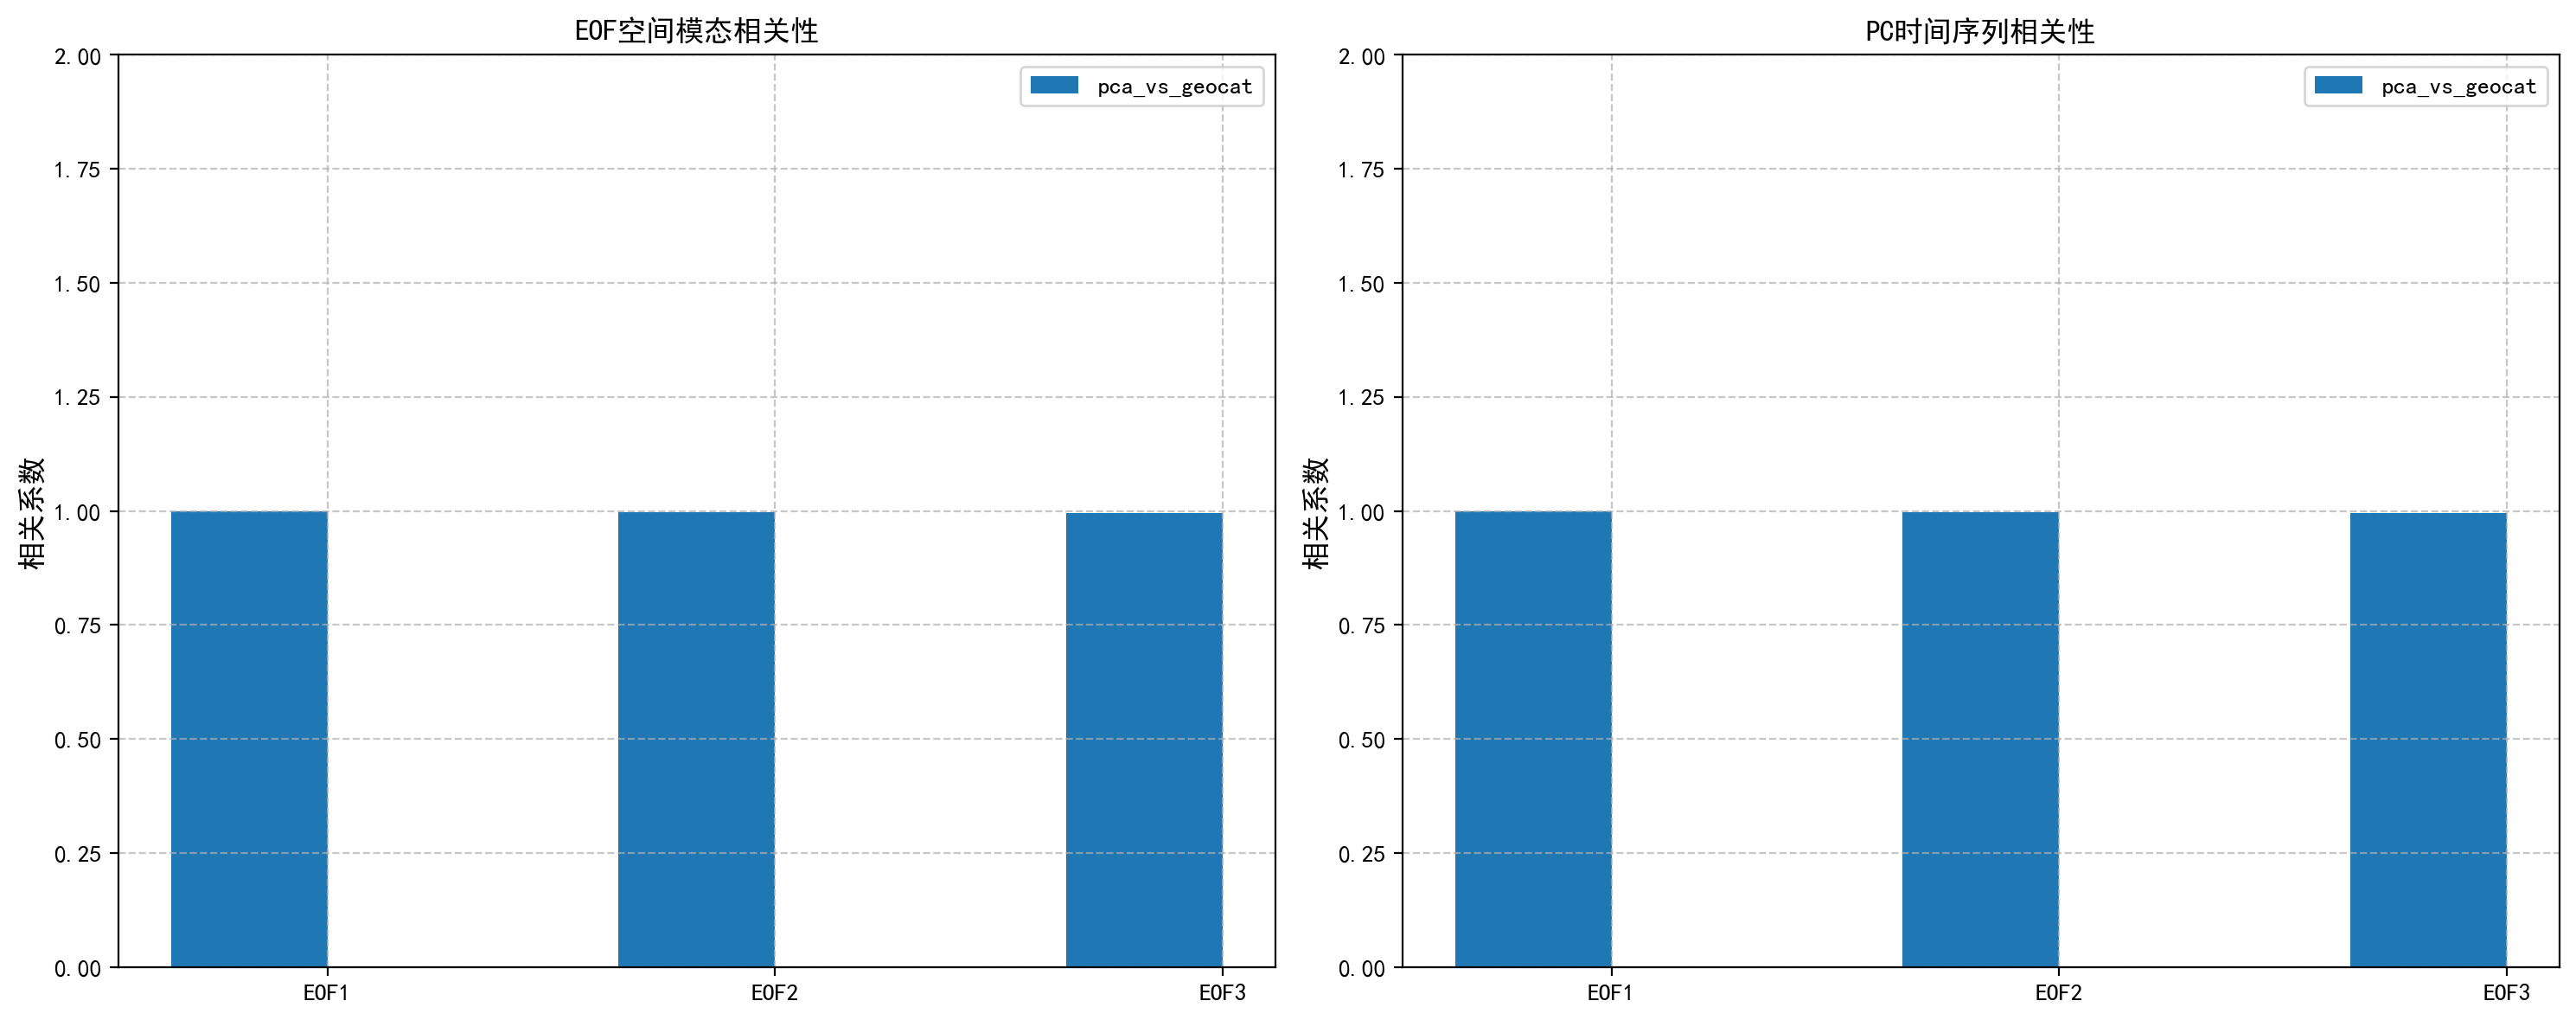

所有对比图已保存到: ./eof_plots/

=== 分析结果摘要 ===

pca 方法:
  解释方差比例: [0.45537656 0.07827968 0.06229725]
  累积解释方差: [0.45537656 0.53365624 0.59595349]

eofs 方法:
  解释方差比例: [0.48220126 0.07897201 0.05866515]
  累积解释方差: [0.48220126 0.56117327 0.61983842]

=== 方法对比 ===

pca_vs_geocat:
  EOF空间模态相关性: [0.9995275507045909, 0.9966099890983259, 0.9945567211424856]
  PC时间序列相关性: [0.9999521762224197, 0.9978388459345944, 0.9950645268004833]


In [28]:

class EOFAnalyzer:
    """封装EOF/PCA分析功能的类"""
    
    def __init__(self, config=None):
        """
        初始化分析器
        
        参数:
            config (dict): 配置参数字典
        """
        # 默认配置
        default_config = {
            'year_start': 1982,
            'year_end': 2020,
            'lat_range': (-45, 45),
            'lon_range': (100, 290),
            'n_components': 3,
            'data_path': './data/oisst_monthly.nc',
            'mask_path': './data/lsmask.nc',
            'var_name': 'sst_new',
            'mask_name': 'mask',
            'season': 'DJF',  # 可选: 'DJF', 'MAM', 'JJA', 'SON', 'annual'
            'detrend': True,
            'detrend_degree': 1,
            'weight_latitude': True,
            'plot_dir': './plots/',
            'nino_region': (-5, 5, -170, -120)  # Nino3.4区域 (latS, latN, lonW, lonE)
        }
        
        # 更新配置
        self.config = default_config.copy()
        if config:
            self.config.update(config)
            
        # 提取常用配置项
        self.latS, self.latN = self.config['lat_range']
        self.lonW, self.lonE = self.config['lon_range']
        self.neof = self.config['n_components']
        
        # 初始化结果存储
        self.results = {}
    
    def load_data(self):
        """加载并预处理数据"""
        print(f"加载数据: {self.config['data_path']}")
        print(f"加载掩膜: {self.config['mask_path']}")
        
        # 加载数据集
        ds = xr.open_dataset(self.config['data_path'])
        dmask = xr.open_dataset(self.config['mask_path'])
        
        # 应用陆地掩膜
        sst = ds[self.config['var_name']].where(
            dmask[self.config['mask_name']].isel(time=0) == 1
        )
        
        # 计算气候态和异常
        ystr, yend = self.config['year_start'], self.config['year_end']
        time_slice = slice(f'{ystr}-01-01', f'{yend}-12-01')
        
        # 计算气候态
        clm = sst.sel(time=time_slice).groupby('time.month').mean(dim='time')
        # 计算异常
        anm = (sst.groupby('time.month') - clm)
        
        # 季节选择
        anm_seasonal = self._select_season(anm)
        
        # 去趋势
        if self.config['detrend']:
            anm_seasonal = self._detrend(anm_seasonal, 'time', self.config['detrend_degree'])
        
        # 纬度权重
        if self.config['weight_latitude']:
            anm_weighted = self._apply_latitude_weights(anm_seasonal)
        else:
            anm_weighted = anm_seasonal
        
        # 选择分析区域
        region_data = anm_weighted.sel(
            lat=slice(self.latS, self.latN), 
            lon=slice(self.lonW, self.lonE)
        ).transpose('time', 'lat', 'lon')
        
        self.data = region_data
        return self.data
    
    def _select_season(self, data):
        """选择特定季节的数据"""
        season_map = {
            'DJF': [12, 1, 2],
            'MAM': [3, 4, 5],
            'JJA': [6, 7, 8],
            'SON': [9, 10, 11],
            'annual': list(range(1, 13))
        }
        
        if self.config['season'] == 'annual':
            return data
        
        # 对应于原代码中的滑动平均
        if self.config['season'] == 'DJF':
            # 滑动平均模拟季节平均
            seasonal_data = data.rolling(time=3, center=True).mean('time')
            # 选择12月的数据代表冬季(DJF)
            ystr, yend = self.config['year_start'], self.config['year_end']
            season_data = seasonal_data.sel(time=slice(f'{ystr}-01-01', f'{yend}-12-01'))
            season_data = season_data.sel(time=season_data['time.month'] == 12)
            return season_data
        else:
            # 对于其他季节，选择对应月份的数据
            months = season_map[self.config['season']]
            return data.sel(time=data['time.month'].isin(months))
    
    def _detrend(self, da, dim, deg=1):
        """沿指定维度去趋势"""
        p = da.polyfit(dim=dim, deg=deg)
        fit = xr.polyval(da[dim], p.polyfit_coefficients)
        return da - fit
    
    def _apply_latitude_weights(self, data):
        """应用纬度权重"""
        # 确保纬度按升序排列
        data_sorted = data.sortby("lat", ascending=True)
        
        # 计算余弦纬度权重
        clat = data_sorted['lat'].astype(np.float64)
        self.weight = np.sqrt(np.cos(np.deg2rad(clat)))
        
        # 应用权重
        weighted_data = data_sorted * self.weight
        weighted_data.attrs = data_sorted.attrs
        
        return weighted_data
    
    def wgt_areaave(self, data, latS, latN, lonW, lonE):
        """计算区域加权平均"""
        lat = data.lat
        lon = data.lon
        
        # 处理经度跨越日期线的情况
        if ((lonW < 0) or (lonE < 0)) and (lon.values.min() > -1):
            adjusted_data = data.assign_coords(lon=((lon + 180) % 360 - 180))
            lon = ((lon + 180) % 360 - 180)
        else:
            adjusted_data = data
        
        # 选择区域
        iplat = lat.where((lat >= latS) & (lat <= latN), drop=True)
        iplon = lon.where((lon >= lonW) & (lon <= lonE), drop=True)
        
        # 应用余弦纬度权重
        self.wgt = np.cos(np.deg2rad(lat))
        
        # 计算加权平均
        region_avg = adjusted_data.sel(lat=iplat, lon=iplon).weighted(self.wgt).mean(
            ("lon", "lat"), skipna=True
        )
        
        return region_avg
    
    def prepare_data_for_pca(self, data_array):
        """处理PCA输入数据，排除NaN值"""
        # 获取原始形状
        time_dim, lat_dim, lon_dim = data_array.shape
        
        # 创建掩膜，标记所有时间点上都有效的网格点
        ocean_mask = ~np.isnan(data_array).any(axis=0)
        
        # 提取掩膜中为True的格点索引
        valid_points = np.where(ocean_mask)
        
        # 创建一个只包含海洋点的二维数组 (time, space)
        ocean_data = np.zeros((time_dim, np.sum(ocean_mask)))
        
        for t in range(time_dim):
            ocean_data[t, :] = data_array[t][valid_points]
        
        return ocean_data, valid_points, (lat_dim, lon_dim)
    
    def run_pca_analysis(self):
        """运行基于sklearn.PCA的EOF分析"""
        print("执行基于sklearn.PCA的EOF分析...")
        
        # 准备数据，处理NaN
        ocean_data, valid_points, spatial_shape = self.prepare_data_for_pca(self.data.values)
        
        # 应用PCA
        pca = PCA(n_components=self.neof)
        pca.fit(ocean_data)
        
        # 获取PC时间序列
        pc_time_series = pca.transform(ocean_data)
        
        # 将EOF空间模态映射回原始网格
        eofs_full = np.full((self.neof, spatial_shape[0], spatial_shape[1]), np.nan)
        for i in range(self.neof):
            eofs_full[i][valid_points] = pca.components_[i, :]
        
        # 创建xarray对象
        pc_da = xr.DataArray(
            pc_time_series,
            dims=('time', 'mode'),
            coords={
                'time': self.data.time,
                'mode': np.arange(self.neof)
            }
        )
        
        eofs_da = xr.DataArray(
            eofs_full,
            dims=('mode', 'lat', 'lon'),
            coords={
                'mode': np.arange(self.neof),
                'lat': self.data.lat,
                'lon': self.data.lon
            }
        )
        
        # 保存结果
        self.results['pca'] = {
            'pcs': pc_da,
            'eofs': eofs_da,
            'explained_variance': pca.explained_variance_ratio_,
            'cumulative_variance': np.cumsum(pca.explained_variance_ratio_)
        }
        
        print(f"PCA分析完成，解释方差: {pca.explained_variance_ratio_}")
        return self.results['pca']
    
    # def run_geocat_analysis(self):
    #     """运行基于geocat.comp的EOF分析"""
    #     print("执行基于geocat.comp的EOF分析...")
        
    #     # 使用geocat.comp计算EOF
    #     eofs = eofunc_eofs(self.data.values, neofs=self.neof, meta=True)
    #     pcs = eofunc_pcs(self.data.values, npcs=self.neof, meta=True)
        
    #     # 标准化PC
    #     # pcs = pcs / pcs.std(dim='time')
    #     pcs['time'] = self.data.time
    #     pcs.attrs['varianceFraction'] = eofs.attrs['varianceFraction']
        
    #     # 创建EOF数据数组
    #     evec = xr.DataArray(
    #         data=eofs, 
    #         dims=('eof', 'lat', 'lon'),
    #         coords={
    #             'eof': np.arange(0, self.neof), 
    #             'lat': self.data.lat, 
    #             'lon': self.data.lon
    #         }
    #     )
        
    #     # 保存结果
    #     self.results['geocat'] = {
    #         'pcs': pcs,
    #         'eofs': evec,
    #         'explained_variance': eofs.attrs['varianceFraction'],
    #         'cumulative_variance': np.cumsum(eofs.attrs['varianceFraction'])
    #     }
        
    #     print(f"geocat分析完成，解释方差: {eofs.attrs['varianceFraction']}")
    #     return self.results['geocat']
    
    def run_eofs_analysis(self):
        """运行基于eofs的EOF分析"""
        print("执行基于eofs的EOF分析...")
        
        # 使用eofs计算EOF
        lat  = self.data.lat.data
        coslat = np.cos(np.deg2rad(lat))
        wgts = np.sqrt(coslat)[..., np.newaxis]
        # 计算EOF & PC
        solver = Eof(self.data.values, weights=wgts,)
        eofs = solver.eofs(neofs=self.neof, eofscaling=0)
        pcs = solver.pcs(npcs=self.neof, pcscaling=0)
        vars = solver.varianceFraction(neigs=self.neof)
        
        # 标准化PC
        # pcs = pcs / pcs.std(dim='time')
        pcs = xr.DataArray(
            data=pcs, 
            dims=('time', 'pc'),
            coords={
                'time': self.data.time, 
                'pc': np.arange(self.neof)
            }
        )
        
        # 创建EOF数据数组
        evec = xr.DataArray(
            data=eofs, 
            dims=('eof', 'lat', 'lon'),
            coords={
                'eof': np.arange(0, self.neof), 
                'lat': self.data.lat, 
                'lon': self.data.lon
            }
        )
        
        # 保存结果
        self.results['eofs'] = {
            'pcs': pcs,
            'eofs': evec,
            'explained_variance': vars,
            'cumulative_variance': np.cumsum(vars)
        }
        
        print(f"eofs分析完成，解释方差: {vars}")
        return self.results['eofs']
    
    def compare_methods(self):
        """比较PCA和geocat两种方法的结果"""
        # 创建比较结果字典
        comparisons = {}
        
        # 计算EOF空间模态的相关性
        eof_correlations = []
        for j in range(self.neof):
            # PCA方法使用'mode'维度，geocat方法使用'eof'维度
            eof1 = self.results['pca']['eofs'].isel(mode=j).values.flatten()
            eof2 = self.results['eofs']['eofs'].isel(eof=j).values.flatten()
            
            # 移除NaN值
            valid = ~(np.isnan(eof1) | np.isnan(eof2))
            if np.sum(valid) > 0:
                corr = np.abs(np.corrcoef(eof1[valid], eof2[valid])[0, 1])
                eof_correlations.append(corr)
            else:
                eof_correlations.append(np.nan)
        
        # 计算PC时间序列的相关性
        pc_correlations = []
        for j in range(self.neof):
            # PCA方法使用'mode'维度，geocat方法使用'eof'维度（或'pc'维度）
            pc1 = self.results['pca']['pcs'].isel(mode=j).values
            pc2 = self.results['eofs']['pcs'].isel(pc=j).values
           
            
            # 移除NaN值
            valid = ~(np.isnan(pc1) | np.isnan(pc2))
            if np.sum(valid) > 0:
                corr = np.abs(np.corrcoef(pc1[valid], pc2[valid])[0, 1])
                pc_correlations.append(corr)
            else:
                pc_correlations.append(np.nan)
        
        # 存储比较结果
        comparisons["pca_vs_geocat"] = {
            'eof_correlations': eof_correlations,
            'pc_correlations': pc_correlations
        }
        
        self.comparisons = comparisons
        return comparisons


    
    
    def plot_comparison(self, save_path=None):
        """绘制不同方法的对比结果"""
        if not hasattr(self, 'results') or len(self.results) < 1:
            print("请先运行分析才能绘图")
            return
        
        # 创建保存目录
        if save_path is None:
            save_path = self.config['plot_dir']
        
        os.makedirs(save_path, exist_ok=True)
        
        # 1. 绘制解释方差比较
        plt.figure(figsize=(10, 6),dpi=200)
        
        for method, result in self.results.items():
            plt.bar(
                np.arange(self.neof) + 0.2 * list(self.results.keys()).index(method), 
                result['explained_variance'] * 100,
                width=0.2,
                label=method
            )
        
        plt.xlabel('EOF模态')
        plt.ylabel('解释方差 (%)')
        plt.title('不同方法的解释方差比较')
        plt.xticks(np.arange(self.neof), [f'EOF{i+1}' for i in range(self.neof)])
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        # plt.savefig(f"{save_path}/variance_comparison.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        # 2. 绘制EOF空间模态对比(前两个模态)
        methods = list(self.results.keys())
        n_plot = min(2, self.neof)  # 只绘制前两个模态
        
        fig = plt.figure(figsize=(15, 12))
        
        for i in range(n_plot):
            for j, method in enumerate(methods):
                ax = fig.add_subplot(n_plot, len(methods), i*len(methods) + j + 1, 
                                    projection=ccrs.PlateCarree(180))
                
                # 获取对应模态
                if method == 'pca':
                    eof_pattern = self.results[method]['eofs'].isel(mode=i).values
                else:
                    eof_pattern = self.results[method]['eofs'].isel(eof=i).values
                
                # 创建网格
                lon_grid, lat_grid = np.meshgrid(self.data.lon, self.data.lat)
                
                # 绘制EOF模态
                levels = np.linspace(-0.05, 0.05, 21)  # 定义色阶
                cs = ax.contourf(lon_grid, lat_grid, eof_pattern, 
                                levels=levels, cmap='RdBu_r', transform=ccrs.PlateCarree())
                
                # 添加海岸线
                ax.coastlines()
                
                # 添加标题
                if method == 'pca':
                    variance = self.results[method]['explained_variance'][i] * 100
                else:
                    variance = self.results[method]['explained_variance'][i] * 100
                
                ax.set_title(f'{method} EOF{i+1} ({variance:.1f}%)')
                
                # 添加网格
                gl = ax.gridlines(draw_labels=True, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
                
                # 添加颜色条
                
                cbar = fig.colorbar(cs, ax=ax, orientation='horizontal', \
                                    aspect=40,shrink=0.65,
                                    pad=0.1)
                cbar.set_label('Loading Pattern')
        
        plt.tight_layout()
        plt.show()
        # plt.savefig(f"{save_path}/eof_spatial_comparison.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        # 3. 绘制PC时间序列对比(前两个模态)
        fig = plt.figure(figsize=(15, 12), dpi=200)
        
        for i in range(n_plot):
            ax = fig.add_subplot(n_plot, 1, i+1)
            
            for j, method in enumerate(methods):
                if method == 'pca':
                    pc = self.results[method]['pcs'].isel(mode=i)
                else:
                    pc = self.results[method]['pcs'].isel(pc=i)
                
                # 为不同方法设置不同线宽
                linewidth = 2.5 if j == 0 else 1.5
                
                ax.plot(pc.time.values, pc.values, label=method, linestyle='--', 
                        linewidth=linewidth)
                    
            ax.set_title(f'PC{i+1} 时间序列对比')
            ax.set_xlabel('Time')
            ax.set_ylabel('Normalized Amplitude')
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend()
        
        plt.tight_layout()
        plt.show()
        # plt.savefig(f"{save_path}/pc_timeseries_comparison.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        # 4. 如果有比较结果，绘制相关性对比
        if hasattr(self, 'comparisons'):
            plt.figure(figsize=(12, 6))
            
            x_labels = [f'EOF{i+1}' for i in range(self.neof)]
            x_pos = np.arange(len(x_labels))
            
            # 设置绘图
            width = 0.35
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6),dpi=200)
            
            for i, (comp_name, comp_data) in enumerate(self.comparisons.items()):
                # EOF空间模态相关性
                ax1.bar(x_pos + i*width, comp_data['eof_correlations'], width, label=comp_name)
                # PC时间序列相关性
                ax2.bar(x_pos + i*width, comp_data['pc_correlations'], width, label=comp_name)
            
            # 设置图1
            ax1.set_ylabel('相关系数')
            ax1.set_title('EOF空间模态相关性')
            ax1.set_xticks(x_pos + width/2)
            ax1.set_xticklabels(x_labels)
            ax1.set_ylim(0, 2)
            ax1.legend()
            ax1.grid(True, linestyle='--', alpha=0.7)
            
            # 设置图2
            ax2.set_ylabel('相关系数')
            ax2.set_title('PC时间序列相关性')
            ax2.set_xticks(x_pos + width/2)
            ax2.set_xticklabels(x_labels)
            ax2.set_ylim(0, 2)
            ax2.legend()
            ax2.grid(True, linestyle='--', alpha=0.7)
            
            plt.tight_layout()
            plt.show()
            # plt.savefig(f"{save_path}/correlation_comparison.png", dpi=300, bbox_inches='tight')
            plt.close()
        
        print(f"所有对比图已保存到: {save_path}")
    
    def run_all(self):
        """运行完整分析流程"""
        # 加载数据
        self.load_data()
        
        # 运行各种方法的EOF分析
        self.run_pca_analysis()
        self.run_eofs_analysis()
        

        
        # # 比较不同方法的结果
        self.compare_methods()
        
        # # 绘制对比图
        self.plot_comparison()
        
        return self.results, self.comparisons if hasattr(self, 'comparisons') else None


# 主程序
if __name__ == "__main__":
    # 配置参数
    config = {
        'year_start': 1982,
        'year_end': 2020,
        'lat_range': (-45, 45),
        'lon_range': (100, 290),
        'n_components': 3,
        'data_path': "I:/oisst_monthly.nc",
        'mask_path': "I:/lsmask.nc",
        'var_name': 'sst',
        'mask_name': 'mask',
        'season': 'DJF',
        'detrend': True,
        'weight_latitude': True,
        'plot_dir': './eof_plots/'
    }
    
    # 创建分析器实例
    analyzer = EOFAnalyzer(config)
    
    # 运行所有分析流程
    results, comparisons = analyzer.run_all()
    
    # 输出结果摘要
    print("\n=== 分析结果摘要 ===")
    for method, result in results.items():
        print(f"\n{method} 方法:")
        print(f"  解释方差比例: {result['explained_variance']}")
        print(f"  累积解释方差: {result['cumulative_variance']}")
    
    if comparisons:
        print("\n=== 方法对比 ===")
        for comp_name, comp_data in comparisons.items():
            print(f"\n{comp_name}:")
            print(f"  EOF空间模态相关性: {comp_data['eof_correlations']}")
            print(f"  PC时间序列相关性: {comp_data['pc_correlations']}")

可以看出来，两种方法的计算结果基本上一致的，虽然第一模态上的符号是相反的